In [1]:
using ForneyLab, Flux.Optimise, Random, Plots

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Warning: Package ForneyLab does not have DataStructures in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added DataStructures as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading DataStructures into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.
  ** incremental compilation may be fatally broken for this module **



Hierarchical Bayesian modeling has a pivotal role in statistical analysis of global quantities that are shared among different experimental groups but culminate in slightly different local effects on each groups. This kind of quantities are of interest to us especially in scientific experiments that are conducted over a number of control and test groups, or polls that are gathered from different groups of people, etc. 

In this notebook, we will apply Hierarchical Bayesian Modelling to a well-known eight school example from Bayesian Data Analysis book (Gelman et. al.) by slightly changing the original example (for details please see the pdf of their book that is freely provided by the authors). In this experiment, we will try to estimate the effect of preperation schools to students' SAT scores. Our ultimate goal is to decide whether preperation schools, in general, has a positive effect on the SAT scores of the students. Suppose that we somehow (maybe by comparing students' SAT scores before and after taking the courses at preparation schools) measured the following treatment effects of schools on each individual.

In [2]:
dataset = [[58.7226956168386, 45.13976354300799, 34.891234306106206, 22.049813810571656, 18.029311822124683, 42.714517401378004, 26.86775400403366, 32.107230568182345],
 [4.606339701921808, -0.43877921447069923, -0.8893574689730634],
 [6.478451882763512, 2.888032369033442, -7.49813190569346, -14.758169441040984, -14.478560265189357, -15.401117821926048, -18.672627310307654],
 [1.846619359098037, -2.68986972978257, 10.054981057055565, 23.763077651153214, -12.555004304724793],
 [6.040319868293942, 19.822216736962826, -8.83951499143022, 2.1115471241811163, -2.4026795198407163, 19.997114297241556, -9.985174142931942, -0.3973994620971628],
 [-8.68576178873407, -1.791407472467292, 9.954292431463115, -11.37327663982918, -2.78835504435457, -1.6674794730107032, 17.851944050272632, 5.547874888293355, -1.5037350724506187],
 [33.31815939613223, -13.432641838306846, 3.5993734745928982],
 [8.268877742477276, 35.26754519612162, 33.05402194461256]]

8-element Array{Array{Float64,1},1}:
 [58.7226956168386, 45.13976354300799, 34.891234306106206, 22.049813810571656, 18.029311822124683, 42.714517401378004, 26.86775400403366, 32.107230568182345]
 [4.606339701921808, -0.43877921447069923, -0.8893574689730634]
 [6.478451882763512, 2.888032369033442, -7.49813190569346, -14.758169441040984, -14.478560265189357, -15.401117821926048, -18.672627310307654]
 [1.846619359098037, -2.68986972978257, 10.054981057055565, 23.763077651153214, -12.555004304724793]
 [6.040319868293942, 19.822216736962826, -8.83951499143022, 2.1115471241811163, -2.4026795198407163, 19.997114297241556, -9.985174142931942, -0.3973994620971628]
 [-8.68576178873407, -1.791407472467292, 9.954292431463115, -11.37327663982918, -2.78835504435457, -1.6674794730107032, 17.851944050272632, 5.547874888293355, -1.5037350724506187]
 [33.31815939613223, -13.432641838306846, 3.5993734745928982]
 [8.268877742477276, 35.26754519612162, 33.05402194461256]

We generated the above dataset randomly from the original example. 

Below, we define a partially non-conjugate hierarchical model for this dataset. In this model specification, we connect non-conjugate factor pairs through a CVI node. CVI node is a factor graph implementation of Conjugate-computation Variational Inference (by Khan and Lin), which carries out a local stochastic natural gradient descent over the free energy variational objective to make inference with non-conjugate factor pairs. 

In [3]:
N = 0
for i=1:8 N += length(dataset[i]) end

In [4]:
# -------------------------------------------
# ForneyLab Model Specification
# -------------------------------------------
graph = FactorGraph()

f(α) = α

@RV α ~ Gamma(.1,.1)
@RV α_ ~ Cvi(α,g=f,opt=ADAM(),num_samples=1000,num_iterations=10000)
@RV β ~ Gamma(.1,.1)
@RV μ ~ GaussianMeanVariance(0,10)
@RV s ~ Gamma(.1,1.)

x = Vector{Variable}(undef, 8)
w = Vector{Variable}(undef, 8)
y = Vector{Variable}(undef, N)

n_count = 0
for i=1:8
    @RV x[i] ~ GaussianMeanPrecision(μ,s)
    @RV w[i] ~ Gamma(α_,β)
    for n=1:length(dataset[i])
        n_count += 1
        @RV y[n_count] ~ GaussianMeanPrecision(x[i],w[i])
        placeholder(y[n_count], :y, index=n_count)
    end
end

In [5]:
# -------------------------------------------
# Approximate Distribution Factorization
# -------------------------------------------

pfz = PosteriorFactorization()

q_α = PosteriorFactor(α, id=:α)
q_β = PosteriorFactor(β, id=:β)
q_μ = PosteriorFactor(μ, id=:μ)
q_s = PosteriorFactor(s, id=:s)
q_x, q_w = Vector{PosteriorFactor}(undef, 8), Vector{PosteriorFactor}(undef, 8)
for i=1:8
    q_x[i] = PosteriorFactor(x[i],id=:x_*i)
    q_w[i] = PosteriorFactor(w[i],id=:w_*i)
end

In [6]:
# Build the algorithm
algo = messagePassingAlgorithm(free_energy=true)

# Generate source code
source_code = algorithmSourceCode(algo, free_energy=true);
eval(Meta.parse(source_code));

In [7]:
# -------------------------------------------
# Execute Inference
# -------------------------------------------
# Prepare posterior factors
marginals = Dict(:α => vague(Gamma), :α_ => vague(Gamma), :β => vague(Gamma), :s => vague(Gamma),
                 :μ => vague(GaussianMeanVariance))

for i=1:8
    marginals[:w_*i] = vague(Gamma)
    marginals[:x_*i] = vague(GaussianMeanPrecision)
end

y_data = []
for i=1:8
    y_data = [y_data;dataset[i]]
end
data = Dict(:y => y_data)

n_its = 10
FE_estimate_CVI = []
for j=1:n_its
    for i=1:8
        step!(:x_*i,data, marginals)
    end
    for i=1:8
        step!(:w_*i,data, marginals)
    end
    stepμ!(data, marginals)
    steps!(data, marginals)
    stepβ!(data, marginals)
    stepα!(data, marginals)
    push!(FE_estimate_CVI, freeEnergy(data, marginals))
end

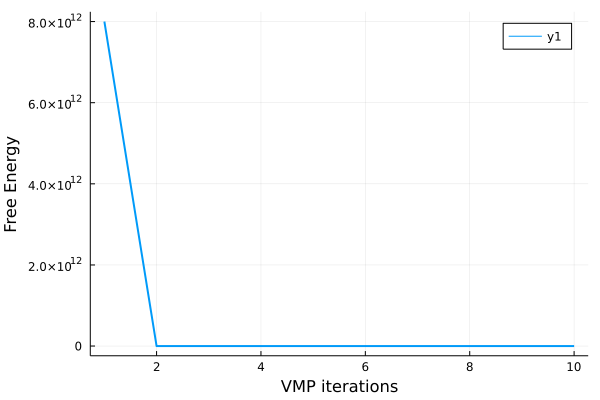

In [8]:
plot(FE_estimate_CVI, lw=2, ylabel="Free Energy", xlabel="VMP iterations")